## setting

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy
device = torch.device('cuda')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        #self.fc1.weight.detach().normal_(0.0, 0.1)
        #self.fc1.bias.detach().normal_(0.0, 0.1)
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        #self.fc2.weight.detach().uniform_(-1,1)
        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes)
        



        self.lsm=nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        
        
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        
        out = self.lsm(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

## Original Training

In [ ]:
learning_rate = 0.002
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
ad=False
if ad:
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1)

    adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
num_epochs=700
dev=100
losslist=[]


totalloss=[]



model.fc2.register_forward_hook(get_activation('fc2'))
#model.fc4.register_forward_hook(get_activation('fc4'))
#model.fc6.register_forward_hook(get_activation('fc6'))

count=0
dd=-10
de=1
for epoch in range(num_epochs):
    loss_epoch=0
    for i, (images, labels) in enumerate(train_loader):  
        

        images = images.view(images.shape[0], -1).to(device)
        labels=labels.to(device)
        #
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        
        
        totalloss.append(loss.item())
        #if epoch<1:
        #    print(count,loss.item())
        loss_epoch=loss_epoch+loss.item()       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count=count+1

        if ad:
            if count==dd:
                with torch.no_grad():
                    output = model(images)
                    adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)

                    
                    
        
    loss_epoch=loss_epoch/len(train_loader) 
    losslist.append(loss_epoch)
    
    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
    if loss_epoch<0.02:
        break

Epoch [1/700], Loss: 2.2346
Epoch [2/700], Loss: 1.8430
Epoch [3/700], Loss: 1.0903


KeyboardInterrupt: ignored

In [ ]:
accuracy(model.to(device),valloader)
out=[losslist,totalloss]

NameError: ignored

## Modify first layer

In [ ]:
out=[]
for p in [-1,0,1,2]:
    print(p)
    learning_rate = 0.002
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-1:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]


    model.fc1.register_forward_hook(get_activation('fc1'))
    model.fc2.register_forward_hook(get_activation('fc2'))
    model.fc3.register_forward_hook(get_activation('fc3'))
    #model.fc6.register_forward_hook(get_activation('fc6'))

    count=0
    dd=3
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):


            

            images = images.view(images.shape[0], -1).to(device)
            labels=labels.to(device)
            #
            # Forward pass
            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)


            

            if ad and ( p>0):
                if count==de*dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(de)],threshold_u=10,threshold_l=0.1,scale=0.23/de,ln=de+1,oflag=1)
                        if de<p:
                            de=de+1
                        else:
                            de=-1
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        #print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.02:
            break
    out.append([losslist,totalloss])
np.save('/content/drive/My Drive/LCNN/output1024.npy', out)

-1
0
Adjusting Layer 1, Kernel Nodes: 643, Adptive Nodes157


In [7]:
out=np.load('/content/drive/My Drive/LCNN/output1024.npy',allow_pickle=True)

Text(0.5, 0, 'Step')

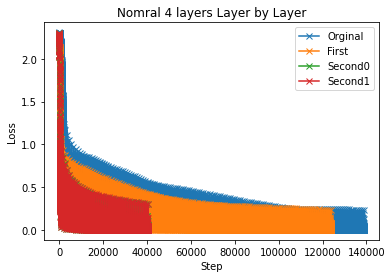

In [10]:
plt.plot(out[0][1],'x-',label='Orginal')
plt.plot(out[1][1],'x-',label='First')
plt.plot(out[2][1],'x-',label='Second0')
plt.plot(out[3][1],'x-',label='Second1')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('Nomral 4 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

Text(0.5, 0, 'Step')

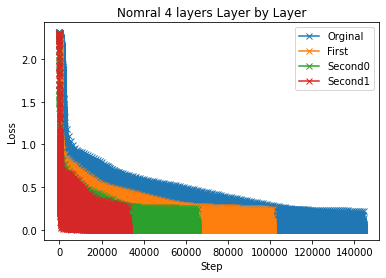

In [ ]:
plt.plot(out[0][1],'x-',label='Orginal')
plt.plot(out[1][1],'x-',label='First')
plt.plot(out[2][1],'x-',label='Second0')
plt.plot(out[3][1],'x-',label='Second1')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('Nomral 4 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

In [ ]:
os.path.exists('learning_results.npy')

False

In [ ]:
def Merge(dict1, dict2): 
    return(dict2.update(dict1)) 
filename='learning_results.npy'
if os.path.exists(filename):
    read_dictionary = np.load(filename,allow_pickle=True).item()
    result =Merge(read_dictionary,result)
    np.save(filename, result)
else:
    np.save(filename, result)

In [ ]:
tt=result100['dd100'][1]
lt=result100['dd100'][0]

In [ ]:
read_dictionary = np.load(filename,allow_pickle=True).item()

In [ ]:
read_dictionary

In [ ]:
out100=[lt,tt]

In [ ]:
out=[losslist,totalloss]

(990.0, 1010.0)

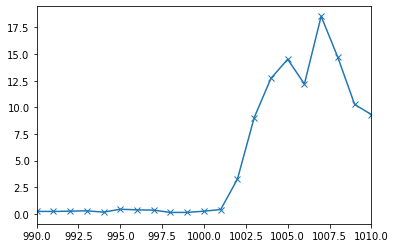

In [ ]:
plt.plot(out[8][1],'x-',label='Second1000')
plt.xlim([990,1010])

In [ ]:
out=[]
for p in [-2,-1,0,1,2,4,8,16,32,64,128]:
    print(p)
    learning_rate = 0.002
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-2:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]



    model.fc2.register_forward_hook(get_activation('fc2'))
    #model.fc4.register_forward_hook(get_activation('fc4'))
    #model.fc6.register_forward_hook(get_activation('fc6'))

    count=0
    dd=p
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):


            

            images = images.view(images.shape[0], -1).to(device)
            labels=labels.to(device)
            #
            # Forward pass
            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)


            

            if ad:
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)  
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        #print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.02:
            break
    out.append([losslist,totalloss])
np.save('/content/drive/My Drive/LCNN/output1024.npy', out)

-2
-1
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
0
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
1
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 82, Adptive Nodes18
2
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 80, Adptive Nodes20
4
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 82, Adptive Nodes18
8
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 80, Adptive Nodes20
16
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
32
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19
64
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 80, Adptive Nodes20
128
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

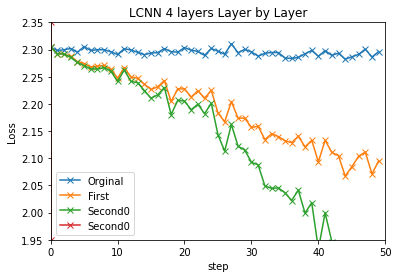

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

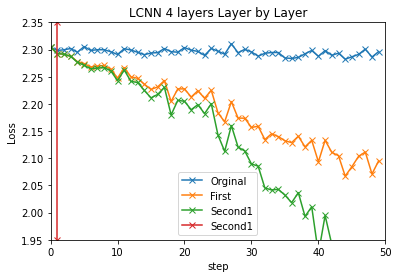

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

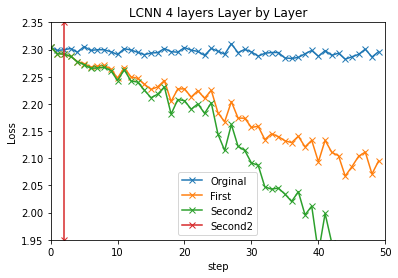

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

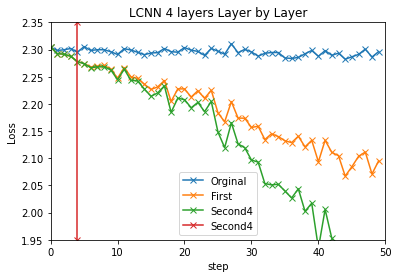

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

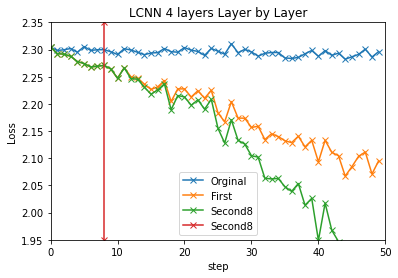

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

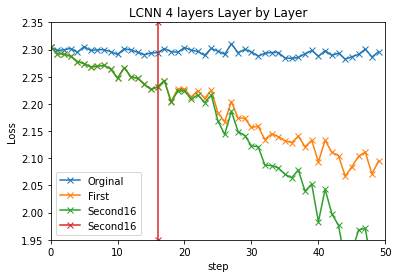

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

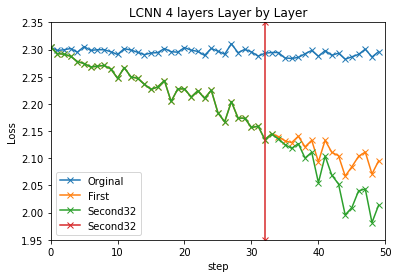

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

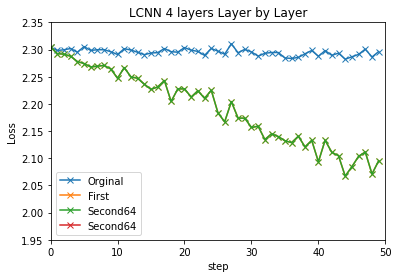

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

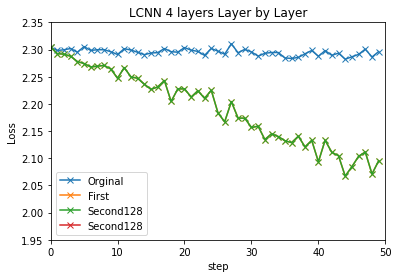

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64,128]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(9):
  # Only select the first 3 tabs, and render others in the background.
  with tb.output_to(i):
    plt.plot(out[0][1][:50],'x-',label='Orginal')
    plt.plot(out[1][1][:50],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][1][:50],'x-',label='Second'+str(k))
    plt.plot([k,k],[1.95,2.35],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    plt.xlim([0,50])
    plt.ylim([1.95,2.35])
    plt.ylabel('Loss')
    plt.xlabel('step')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

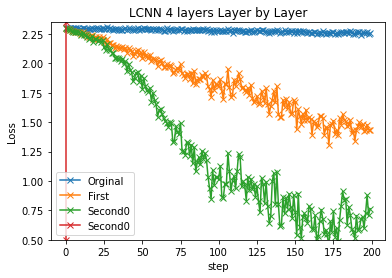

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

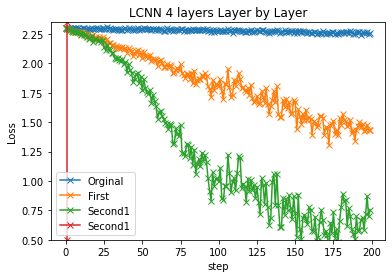

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

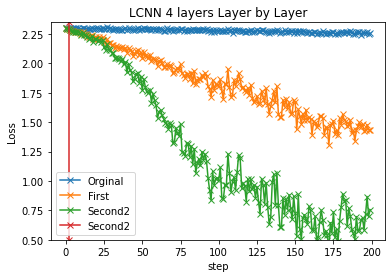

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

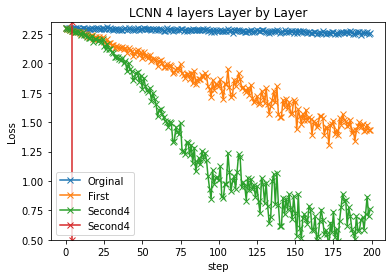

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

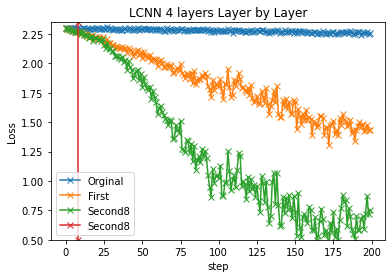

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

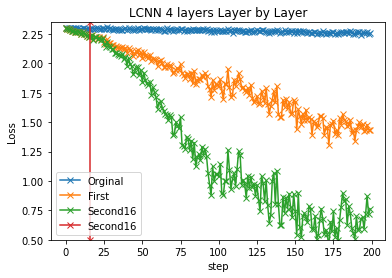

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

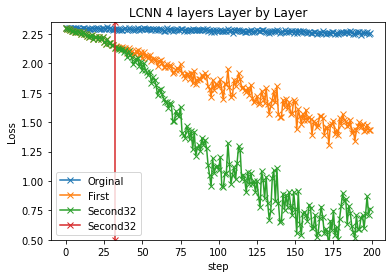

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

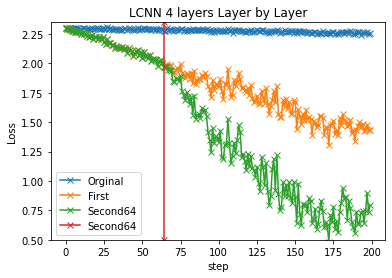

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

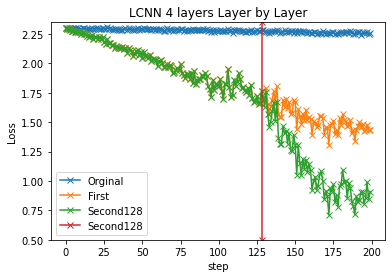

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64,128]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(9):
  # Only select the first 3 tabs, and render others in the background.
  with tb.output_to(i):
    plt.plot(out[0][1][:200],'x-',label='Orginal')
    plt.plot(out[1][1][:200],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][1][:200],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.plot([k,k],[0.5,2.35],'x-',label='Second'+str(k))
    plt.legend()
    plt.ylim([0.5,2.35])
    plt.ylabel('Loss')
    plt.xlabel('step')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

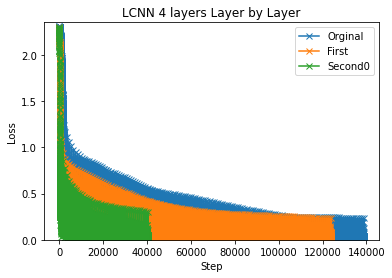

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

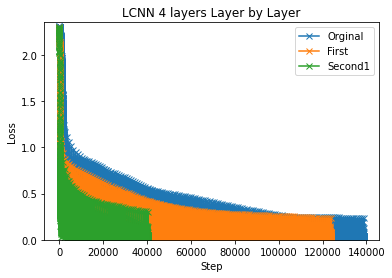

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

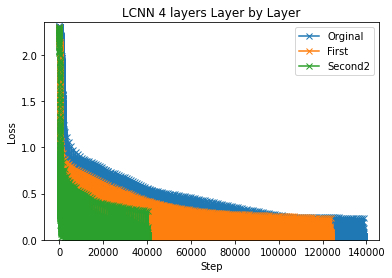

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

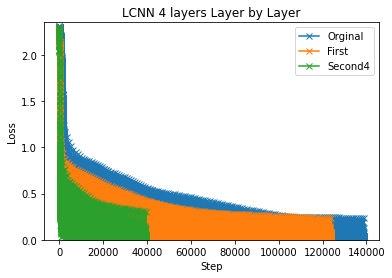

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

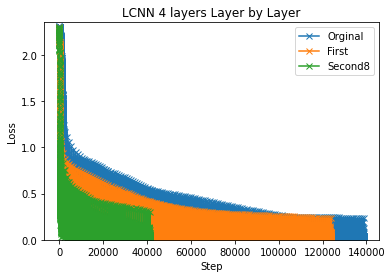

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

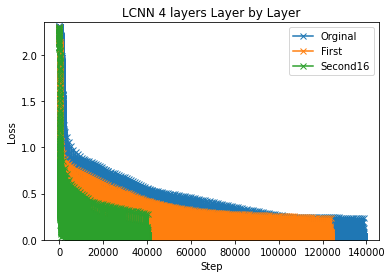

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

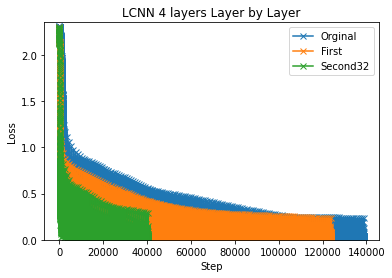

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

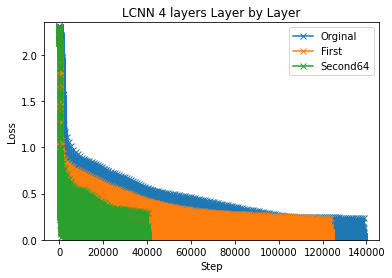

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

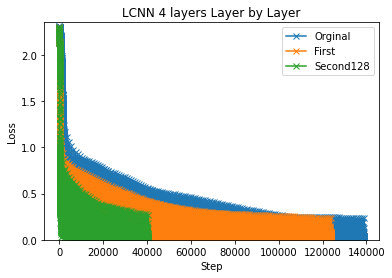

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64,128]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(9):
  with tb.output_to(i):
    plt.plot(out[0][1],'x-',label='Orginal')
    plt.plot(out[1][1],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][1],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    plt.ylim([0,2.35])
    plt.ylabel('Loss')
    plt.xlabel('Step')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

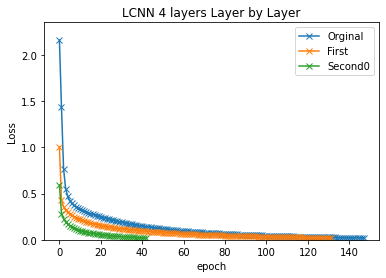

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

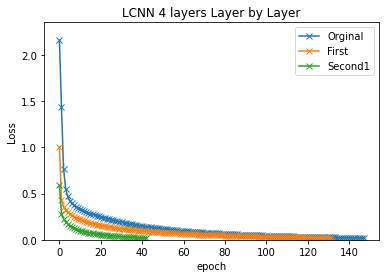

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

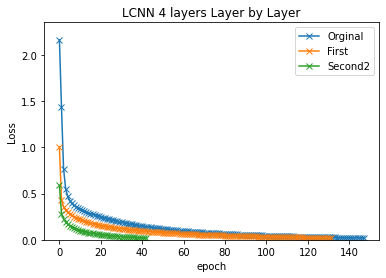

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

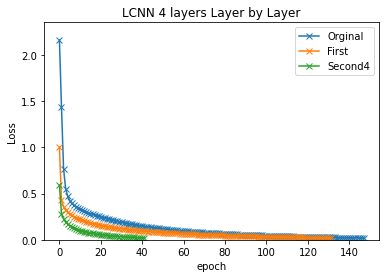

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

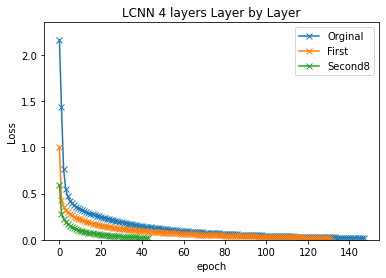

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

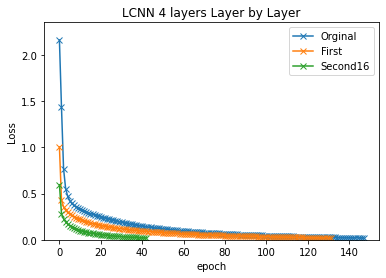

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

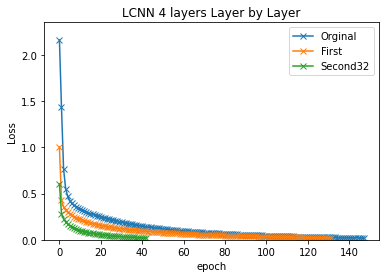

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

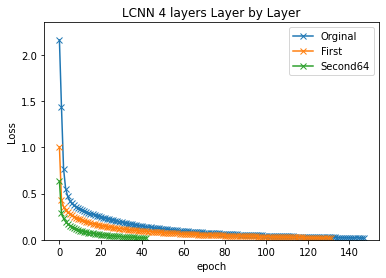

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

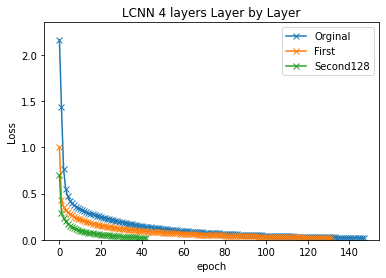

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,4,8,16,32,64,128]
tb = widgets.TabBar([str(i) for i in pl])
for i in range(9):
  with tb.output_to(i):
    plt.plot(out[0][0],'x-',label='Orginal')
    plt.plot(out[1][0],'x-',label='First')
    k=pl[i]
    plt.plot(out[i+2][0],'x-',label='Second'+str(k))
    plt.title('LCNN 4 layers Layer by Layer')
    plt.legend()
    plt.ylim([0,2.35])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.show()

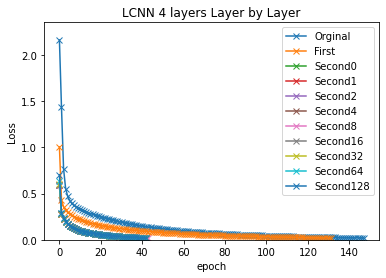

In [ ]:
pl=[0,1,2,4,8,16,32,64,128]
plt.plot(out[0][0],'x-',label='Orginal')
plt.plot(out[1][0],'x-',label='First')
for i in range(9):
    k=pl[i]
    plt.plot(out[i+2][0],'x-',label='Second'+str(k))
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylim([0,2.35])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

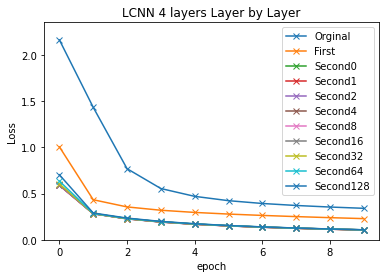

In [ ]:
pl=[0,1,2,4,8,16,32,64,128]
plt.plot(out[0][0][:10],'x-',label='Orginal')
plt.plot(out[1][0][:10],'x-',label='First')
for i in range(9):
    k=pl[i]
    plt.plot(out[i+2][0][:10],'x-',label='Second'+str(k))
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylim([0,2.35])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
out=[]
for p in [1000]:
    print(p)
    learning_rate = 0.002
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-2:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]



    model.fc2.register_forward_hook(get_activation('fc2'))
    #model.fc4.register_forward_hook(get_activation('fc4'))
    #model.fc6.register_forward_hook(get_activation('fc6'))

    count=0
    dd=p
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):


            

            images = images.view(images.shape[0], -1).to(device)
            labels=labels.to(device)
            #
            # Forward pass
            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)


            

            if ad:
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)  
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        #print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.02:
            break
    out.append([losslist,totalloss])

1000
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 80, Adptive Nodes20


KeyboardInterrupt: ignored

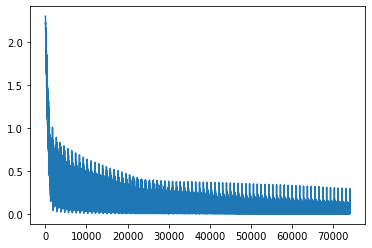

In [ ]:
plt.plot(totalloss)